### キャッシュファイルの内容
- 複数のシミュレーション条件（Vtip, Rtip, Htip）ごとの水平方向ポテンシャル分布データ
- 各キャッシュファイルには以下の配列が格納されています：
    - `Vtip`, `Rtip`, `Htip`: 各パラメータの値リスト
    - `r`: 距離（nm）
    - `data`: ポテンシャル分布データ（V）

In [1]:
import os
import json
from itertools import product
import numpy as np
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.optimize import brentq, minimize
import matplotlib.pyplot as plt

### 読み込み

+ `data`の形状は `(Vtip数, Rtip数, Htip数, r数)` です。
+ `data[i,j,k,l]` には、`Vtip[i]`, `Rtip[j]`, `Htip[k]` に対応する距離 `r[l]` でのポテンシャル値が格納されています。計算が収束しなかった部分は `np.nan` となっています。

In [2]:
cache = np.load('_ring_radius_cache/outputs+20251027_215518.npz')
Vtip = cache['Vtip']
Rtip = cache['Rtip']
Htip = cache['Htip']
r = cache['r']
data = cache['data']

print(f"{data.shape=}")

data.shape=(25, 9, 31, 200)


### リング半径の計算

リング半径を計算するには逆関数を使用します。以下は実装例です。

`make_ring_radius_function` は以下の関数を生成します。
```py
ring_radius_func(Rtip_val, Vring_val, Vtip_val, Htip_val)
```

In [3]:
def make_ring_radius_function(
    Vtip_values, Rtip_values, Htip_values, r, data, verbose=False
):
    # RegularGridInterpolator の初期化に時間がかかるので注意
    interpolator = RegularGridInterpolator(
        (Vtip_values, Rtip_values, Htip_values, r),
        data,
        method="linear"
        if (len(Vtip_values) < 4 or len(Rtip_values) < 4 or len(Htip_values) < 4)
        else "cubic",
        bounds_error=False,
        fill_value=None,  # extrapolate
    )

    def f(Rtip_target, Vring_target, Vtip_query, Htip_query, verbose=verbose):
        if verbose:
            if Rtip_target < Rtip_values.min() or Rtip_target > Rtip_values.max():
                print(
                    f"Warning: Rtip={Rtip_target} is outside range [{Rtip_values.min()}, {Rtip_values.max()}]"
                )
            if Vtip_query < Vtip_values.min() or Vtip_query > Vtip_values.max():
                print(
                    f"Warning: Vtip={Vtip_query} is outside range [{Vtip_values.min()}, {Vtip_values.max()}]"
                )
            if Htip_query < Htip_values.min() or Htip_query > Htip_values.max():
                print(
                    f"Warning: Htip={Htip_query} is outside range [{Htip_values.min()}, {Htip_values.max()}]"
                )
        query_points = np.array(
            [[Vtip_query, Rtip_target, Htip_query, r_val] for r_val in r]
        )
        potential_profile = interpolator(query_points)

        f_interp = interp1d(
            r, potential_profile, kind="cubic", bounds_error=False, fill_value=np.nan
        )

        pot_min, pot_max = potential_profile.min(), potential_profile.max()
        if not (pot_min <= Vring_target <= pot_max):
            if verbose:
                print(
                    f"Warning: Vring={Vring_target} is outside potential range [{pot_min:.3f}, {pot_max:.3f}]"
                )
            return np.nan

        def objective(r_val):
            return f_interp(r_val) - Vring_target

        r_result = brentq(objective, r.min(), r.max())
        return r_result

    return f

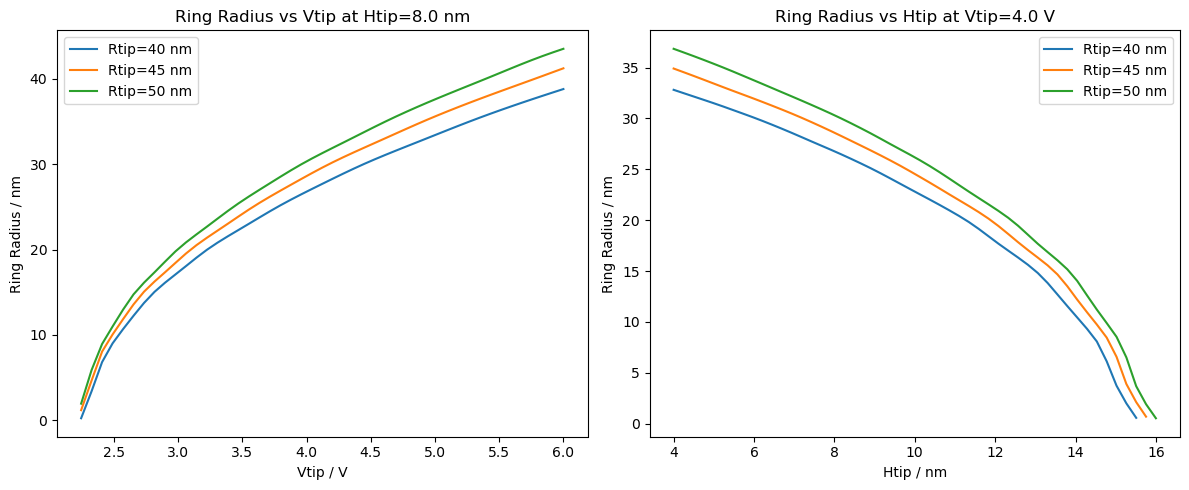

In [4]:
Rtip_targets = [40, 45, 50] # nm
Vring_target = 0.2 # V

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# axes[0]: Vtip vs ring radius at fixed Htip
# axes[1]: Htip vs ring radius at fixed Vtip
Vtip_values = np.linspace(2, 6, 50)
Vtip_fixed = 4.0 # V
Vtip_fixed_neg = -2.0 # V
Htip_values = np.linspace(4, 16, 50)
Htip_fixed = 8.0 # nm
cmap = plt.get_cmap("tab10")
data = np.nan_to_num(data, nan=0.0)
ring_radius_func = make_ring_radius_function(
    Vtip, Rtip, Htip, r, data
)
for i, Rtip_target in enumerate(Rtip_targets):
    ring_radii_Vtip = [
        ring_radius_func(Rtip_target, Vring_target, Vtip_val, Htip_fixed) for Vtip_val in Vtip_values
    ]
    ring_radii_Htip = [
        ring_radius_func(Rtip_target, Vring_target, Vtip_fixed, Htip_val) for Htip_val in Htip_values
    ]
    axes[0].plot(Vtip_values, ring_radii_Vtip, color=cmap(i), label=f"Rtip={Rtip_target} nm")
    axes[1].plot(Htip_values, ring_radii_Htip, color=cmap(i), label=f"Rtip={Rtip_target} nm")
axes[0].set_xlabel("Vtip / V")
axes[0].set_ylabel("Ring Radius / nm")
axes[0].set_title(f"Ring Radius vs Vtip at Htip={Htip_fixed} nm")
axes[0].legend()
axes[1].set_xlabel("Htip / nm")
axes[1].set_ylabel("Ring Radius / nm")
axes[1].set_title(f"Ring Radius vs Htip at Vtip={Vtip_fixed} V")
axes[1].legend()
plt.tight_layout()
plt.show()

### フィッティング

In [5]:
print("\n".join(os.listdir("data")))

exp_data_SiO2_25nm_Vtip+.csv
exp_data_ringA_Vtip+.csv
exp_data_z_SiO2_25nm_Vtip+.csv
exp_data_ringB_Vtip+.csv
exp_data_z_ringA_Vtip+.csv
exp_data.csv
exp_data_z.csv
exp_data_z_ringB_Vtip+.csv


In [6]:
# CPD = -0.9 # V
CPD = 0 # V

r_Htip_pos = np.loadtxt("data/exp_data_z_ringA_Vtip+.csv", delimiter=',')
r_Vtip_pos = np.loadtxt("data/exp_data_ringA_Vtip+.csv", delimiter=',')
mask = r_Vtip_pos[:, 0] <= 6.0-CPD
r_Vtip_pos = r_Vtip_pos[mask]
r_Htip_neg = np.loadtxt("data/exp_data_z.csv", delimiter=',', skiprows=1)
r_Vtip_neg = np.loadtxt("data/exp_data.csv", delimiter=',', skiprows=1)
r_Vtip_neg[:, 0] = -r_Vtip_neg[:, 0]  # Make voltages negative
mask = r_Vtip_neg[:, 0] >= -6.0-CPD
r_Vtip_neg = r_Vtip_neg[mask]

In [5]:
def fitting_function(ring_radius_func, r_vs_Vtip, r_vs_Htip, Vtip_fixed, Htip_fixed, initial_guesses, CPD=CPD):
    # find best (Rtip, Vring) that fits ring radius dependence on Vtip and Htip
    def objective(params):
        Rtip_fit, Vring_fit = params
        # Vtip dependence
        Vtip_exp = r_vs_Vtip[:, 0]
        r_exp_Vtip = r_vs_Vtip[:, 1]
        r_fit_Vtip = np.array([
            ring_radius_func(Rtip_fit, Vring_fit, Vtip_val+CPD, Htip_fixed) for Vtip_val in Vtip_exp
        ])
        # Htip dependence
        Htip_exp = r_vs_Htip[:, 0]
        r_exp_Htip = r_vs_Htip[:, 1]
        r_fit_Htip = np.array([
            ring_radius_func(Rtip_fit, Vring_fit, Vtip_fixed+CPD, Htip_val) for Htip_val in Htip_exp
        ])
        # Calculate total error
        error_Vtip = np.nanmean((r_exp_Vtip - r_fit_Vtip) ** 2) 
        error_Htip = np.nanmean((r_exp_Htip - r_fit_Htip) ** 2)
        total_error = np.nansum([error_Vtip, error_Htip])
        return total_error
    
    result_list = []
    for initial_guess in initial_guesses:
        result = minimize(objective, initial_guess, method='Nelder-Mead')
        Rtip_opt, Vring_opt = result.x
        result_list.append((Rtip_opt, Vring_opt, objective([Rtip_opt, Vring_opt])))
        print(f"Init Rtip: {initial_guess[0]:.2f} nm, Vring: {initial_guess[1]:.3f} V => Fitted Rtip: {Rtip_opt:.2f} nm, Vring: {Vring_opt:.3f} V, Objective: {result.fun:.6f}")

    best_result = min(result_list, key=lambda x: x[2])
    return best_result, objective

In [8]:
initial_guesses = product([40.0, 45.0, 50.0], [0.18, 0.19, 0.2])
result, objective_func = fitting_function(ring_radius_func, r_Vtip_pos, r_Htip_pos, Vtip_fixed, Htip_fixed, initial_guesses, CPD=CPD)
Rtip_opt, Vring_opt, objective = result
print(f"Best result: {Rtip_opt:.2f} nm, Vring: {Vring_opt:.3f} V, Objective: {objective:.6f}")

Init Rtip: 40.00 nm, Vring: 0.180 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 40.00 nm, Vring: 0.190 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 40.00 nm, Vring: 0.200 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 45.00 nm, Vring: 0.180 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 45.00 nm, Vring: 0.190 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 45.00 nm, Vring: 0.200 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 50.00 nm, Vring: 0.180 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 50.00 nm, Vring: 0.190 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Init Rtip: 50.00 nm, Vring: 0.200 V => Fitted Rtip: 42.62 nm, Vring: 0.205 V, Objective: 9.139939
Best result: 42.62 nm, Vring: 0.205 V, Objective: 9.139939


In [9]:
best_r_Htip_pos = np.array([
    ring_radius_func(Rtip_opt, Vring_opt, Vtip_fixed+CPD, Htip_val) for Htip_val in r_Htip_pos[:, 0]
])
best_r_Vtip_pos = np.array([
    ring_radius_func(Rtip_opt, Vring_opt, Vtip_val+CPD, Htip_fixed) for Vtip_val in r_Vtip_pos[:, 0]
])

In [10]:
initial_guesses = product([40.0, 45.0, 50.0], [0.05, 0.06, 0.07])
result_neg, objective_func_neg = fitting_function(ring_radius_func, r_Vtip_neg, r_Htip_neg, Vtip_fixed_neg, Htip_fixed, initial_guesses, CPD=CPD)
Rtip_opt_neg, Vring_opt_neg, objective_neg = result_neg
print(f"Negative Fitted Rtip: {Rtip_opt_neg:.2f} nm, Vring: {Vring_opt_neg:.3f} V, Objective: {objective_neg:.6f}")

Init Rtip: 40.00 nm, Vring: 0.050 V => Fitted Rtip: 40.35 nm, Vring: 0.105 V, Objective: 3.606789
Init Rtip: 40.00 nm, Vring: 0.060 V => Fitted Rtip: 49.37 nm, Vring: 0.094 V, Objective: 19.081954
Init Rtip: 40.00 nm, Vring: 0.070 V => Fitted Rtip: 39.55 nm, Vring: 0.106 V, Objective: 3.660181
Init Rtip: 45.00 nm, Vring: 0.050 V => Fitted Rtip: 79.44 nm, Vring: 0.037 V, Objective: 124.160165
Init Rtip: 45.00 nm, Vring: 0.060 V => Fitted Rtip: 73.06 nm, Vring: 0.053 V, Objective: 97.781315
Init Rtip: 45.00 nm, Vring: 0.070 V => Fitted Rtip: 40.43 nm, Vring: 0.105 V, Objective: 3.607877
Init Rtip: 50.00 nm, Vring: 0.050 V => Fitted Rtip: 73.70 nm, Vring: 0.055 V, Objective: 91.026590
Init Rtip: 50.00 nm, Vring: 0.060 V => Fitted Rtip: 73.70 nm, Vring: 0.055 V, Objective: 91.026590
Init Rtip: 50.00 nm, Vring: 0.070 V => Fitted Rtip: 39.57 nm, Vring: 0.106 V, Objective: 3.660152
Negative Fitted Rtip: 40.35 nm, Vring: 0.105 V, Objective: 3.606789


In [11]:
# Rtip_opt_neg =45
# Vring_opt_neg = 0.05
best_r_Htip_neg = np.array([
    ring_radius_func(Rtip_opt_neg, Vring_opt_neg, Vtip_fixed_neg+CPD, Htip_val, verbose=True) for Htip_val in r_Htip_neg[:, 0]
])
best_r_Vtip_neg = np.array([
    ring_radius_func(Rtip_opt_neg, Vring_opt_neg, Vtip_val+CPD, Htip_fixed, verbose=True) for Vtip_val in r_Vtip_neg[:, 0]
])

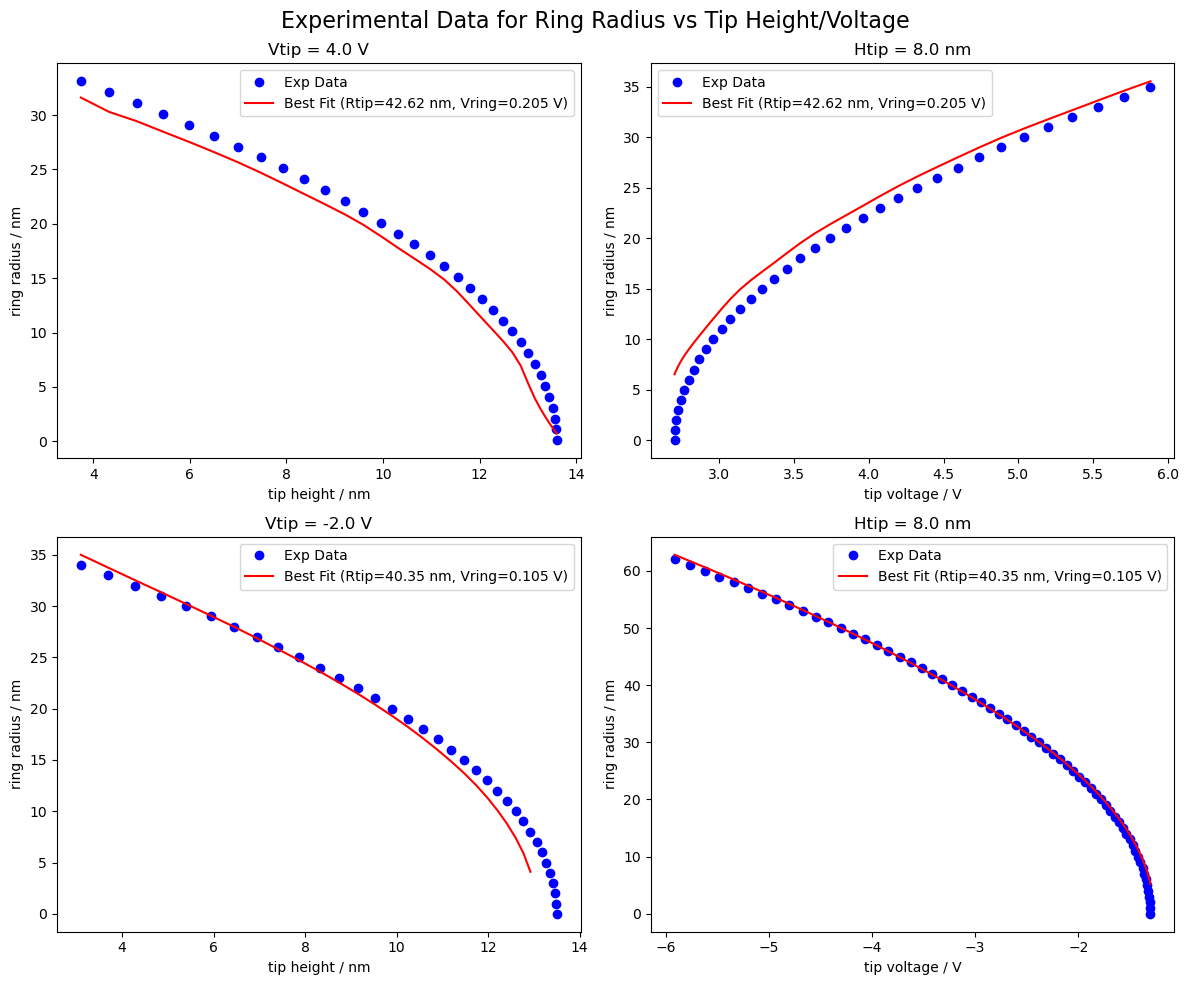

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].plot(r_Htip_pos[:, 0], r_Htip_pos[:, 1], 'bo', label='Exp Data')
axes[0, 0].plot(r_Htip_pos[:, 0], best_r_Htip_pos, 'r-', label=f"Best Fit (Rtip={Rtip_opt:.2f} nm, Vring={Vring_opt:.3f} V)")
axes[0, 0].set_xlabel("tip height / nm")
axes[0, 0].set_ylabel("ring radius / nm")
axes[0, 0].set_title("Vtip = 4.0 V")
axes[0, 0].legend()
axes[0, 1].plot(r_Vtip_pos[:, 0], r_Vtip_pos[:, 1], 'bo', label='Exp Data')
axes[0, 1].plot(r_Vtip_pos[:, 0], best_r_Vtip_pos, 'r-', label=f"Best Fit (Rtip={Rtip_opt:.2f} nm, Vring={Vring_opt:.3f} V)")
axes[0, 1].set_xlabel("tip voltage / V")
axes[0, 1].set_ylabel("ring radius / nm")
axes[0, 1].set_title("Htip = 8.0 nm")
axes[0, 1].legend()
axes[1, 0].plot(r_Htip_neg[:, 0], r_Htip_neg[:, 1], 'bo', label='Exp Data')
axes[1, 0].plot(r_Htip_neg[:, 0], best_r_Htip_neg, 'r-', label=f"Best Fit (Rtip={Rtip_opt_neg:.2f} nm, Vring={Vring_opt_neg:.3f} V)")
axes[1, 0].set_xlabel("tip height / nm")
axes[1, 0].set_ylabel("ring radius / nm")
axes[1, 0].set_title("Vtip = -2.0 V")
axes[1, 0].legend()
axes[1, 1].plot(r_Vtip_neg[:, 0], r_Vtip_neg[:, 1], 'bo', label='Exp Data')
axes[1, 1].plot(r_Vtip_neg[:, 0], best_r_Vtip_neg, 'r-', label=f"Best Fit (Rtip={Rtip_opt_neg:.2f} nm, Vring={Vring_opt_neg:.3f} V)")
axes[1, 1].set_xlabel("tip voltage / V")
axes[1, 1].set_ylabel("ring radius / nm")
axes[1, 1].set_title("Htip = 8.0 nm")
axes[1, 1].legend()
fig.suptitle("Experimental Data for Ring Radius vs Tip Height/Voltage", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# fitting results
if not os.path.exists("fitting_results"):
    os.makedirs("fitting_results")
metadata = {
    "CPD": CPD,
    "negative_Vtip": {
        "Rtip_opt": Rtip_opt_neg,
        "Vring_opt": Vring_opt_neg,
        "objective": objective_neg,
    },
    "positive_Vtip": {
        "Rtip_opt": Rtip_opt,
        "Vring_opt": Vring_opt,
        "objective": objective,
    },
}
with open("fitting_results/fitting_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)
np.savetxt("fitting_results/best_r_vs_Htip_pos.csv", np.column_stack((r_Htip_pos[:, 0], best_r_Htip_pos)), delimiter=',', header='Htip(nm),ring_radius(nm)', comments='')
np.savetxt("fitting_results/best_r_vs_Vtip_pos.csv", np.column_stack((r_Vtip_pos[:, 0], best_r_Vtip_pos)), delimiter=',', header='Vtip(V),ring_radius(nm)', comments='')
np.savetxt("fitting_results/best_r_vs_Htip_neg.csv", np.column_stack((r_Htip_neg[:, 0], best_r_Htip_neg)), delimiter=',', header='Htip(nm),ring_radius(nm)', comments='')
np.savetxt("fitting_results/best_r_vs_Vtip_neg.csv", np.column_stack((r_Vtip_neg[:, 0], best_r_Vtip_neg)), delimiter=',', header='Vtip(V),ring_radius(nm)', comments='')

### Grid Spectroscopy

In [7]:
# load grid spectroscopy data
gs_15 = np.loadtxt('20250714/Grid Spectroscopy015_OC_M1_Excitation.txt', skiprows=1).reshape(-1, 80)
gs_16 = np.loadtxt('20250714/Grid Spectroscopy016_OC_M1_Excitation.txt', skiprows=1)
gs_17 = np.loadtxt('20250714/Grid Spectroscopy017_OC_M1_Excitation.txt', skiprows=1)
gs_18 = np.loadtxt('20250714/Grid Spectroscopy018_OC_M1_Excitation.txt', skiprows=1).reshape(-1, 80)
print(gs_15.shape, gs_16.shape, gs_17.shape, gs_18.shape)

# load optimized parameters from fitting results
with open("fitting_results/fitting_metadata.json", "r") as f:
    fitting_metadata = json.load(f)
print('--- Fitting Results ---')
print(json.dumps(fitting_metadata, indent=4))

(201, 80) (161, 80) (201, 80) (201, 80)
--- Fitting Results ---
{
    "CPD": 0,
    "negative_Vtip": {
        "Rtip_opt": 40.353070585785304,
        "Vring_opt": 0.1050008628288586,
        "objective": 3.606789019705115
    },
    "positive_Vtip": {
        "Rtip_opt": 42.617388268295144,
        "Vring_opt": 0.20498365351060555,
        "objective": 9.139939122919227
    }
}


In [54]:
# r_Htip_pos = np.loadtxt("data/exp_data_z_ringA_Vtip+.csv", delimiter=',')
# r_Vtip_pos = np.loadtxt("data/exp_data_ringA_Vtip+.csv", delimiter=',')
# mask = r_Vtip_pos[:, 0] <= 6.0-CPD
# r_Vtip_pos = r_Vtip_pos[mask]
# r_Htip_neg = np.loadtxt("data/exp_data_z.csv", delimiter=',', skiprows=1)
# r_Vtip_neg = np.loadtxt("data/exp_data.csv", delimiter=',', skiprows=1)
scales = {
    "gs_15": {
        "fitting_name": "positive_Vtip",
        "peak_profile": "data/exp_data_z_ringA_Vtip+.csv",
        "x": { "unit": "nm", "start": 0-80, "end": 167.26-80 },
        "y": { "label": "Tip height", "unit": "nm", "start": 3, "end": 23 },
    },
    "gs_16": {
        "fitting_name": "positive_Vtip",
        "peak_profile": "data/exp_data_ringA_Vtip+.csv",
        "x": { "unit": "nm", "start": 0-80, "end": 167.26-80 },
        "y": { "label": "Tip bias", "unit": "V", "start": 8, "end": 0 },
    },
    "gs_17": {
        "fitting_name": "negative_Vtip",
        "peak_profile": "data/exp_data.csv",
        "x": { "unit": "nm", "start": 0-80, "end": 150.0-80 },
        "y": { "label": "Tip bias", "unit": "V", "start": 2, "end": -8 },
    },
    "gs_18": {
        "fitting_name": "positive_Vtip",
        "peak_profile": "data/exp_data_z.csv",
        "x": { "unit": "nm", "start": 0-80, "end": 150.0-80 },
        "y": { "label": "Tip height", "unit": "nm", "start": 3, "end": 23 },
    },
}

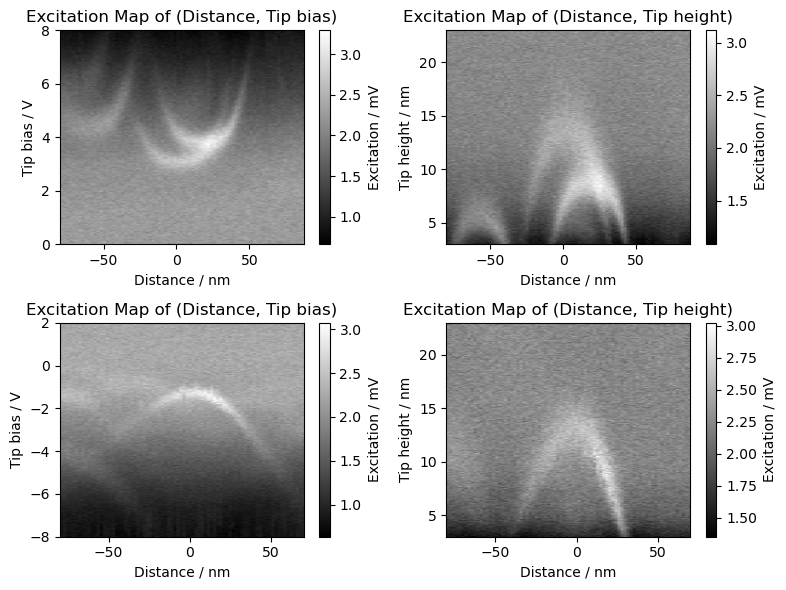

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for i, gs_data_key in enumerate(['gs_16', 'gs_15', 'gs_17', 'gs_18']):
    gs = eval(gs_data_key)
    scale = scales[gs_data_key]
    fitting_name = scale["fitting_name"]
    Rtip_fit = fitting_metadata[fitting_name]["Rtip_opt"]
    Vring_fit = fitting_metadata[fitting_name]["Vring_opt"]
    ystart = scale["y"]["start"]
    yend = scale["y"]["end"]
    if ystart > yend:
        gs = np.flipud(gs)
        ystart, yend = yend, ystart
    x_vals = np.linspace(scale["x"]["start"], scale["x"]["end"], gs.shape[1])
    y_vals = np.linspace(ystart, yend, gs.shape[0])
    X, Y = np.meshgrid(x_vals, y_vals)
    im = axes[i].imshow(gs*1e3, extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()), aspect='auto', origin='lower', cmap='gray')
    axes[i].set_xlim(x_vals.min(), x_vals.max())
    axes[i].set_ylim(y_vals.min(), y_vals.max())
    axes[i].set_xlabel(f"Distance / {scale['x']['unit']}")
    axes[i].set_ylabel(f"{scale['y']['label']} / {scale['y']['unit']}")
    axes[i].set_title(f"Excitation Map of (Distance, {scale['y']['label']})")
    fig.colorbar(im, ax=axes[i], label='Excitation / mV')
    
    # # Overlay experimental peak profile
    # r_peak_profile = np.loadtxt(scale["peak_profile"], delimiter=',', skiprows=1)
    # if scale["peak_profile"] == "data/exp_data.csv":
    #     r_peak_profile[:, 0] = -r_peak_profile[:, 0]  # Make voltages negative
    # axes[i].plot(r_peak_profile[:, 1], r_peak_profile[:, 0], 'b.', label='Fitting Targets')

    # # Overlay fitted ring radius contours
    # if scale["y"]["label"] == "Tip height":
    #     Htip_vals = y_vals
    #     Vtip_fixed = 4.0 if fitting_name == "positive_Vtip" else -2.0
    #     ring_radii = np.array([
    #         ring_radius_func(Rtip_fit, Vring_fit, Vtip_fixed+CPD, Htip_val) for Htip_val in Htip_vals
    #     ])
    #     axes[i].plot(ring_radii, Htip_vals, 'r-', label='Fitted Ring Radius')
    # else:
    #     Vtip_vals = y_vals
    #     Htip_fixed = 8.0
    #     ring_radii = np.array([
    #         ring_radius_func(Rtip_fit, Vring_fit, Vtip_val+CPD, Htip_fixed) for Vtip_val in Vtip_vals
    #     ])
    #     axes[i].plot(ring_radii, Vtip_vals, 'r-', label='Fitted Ring Radius')
    # axes[i].legend()
plt.tight_layout()
plt.show()

### 不確かさの見積もり

--- Fitting Results ---
{
    "CPD": 0,
    "negative_Vtip": {
        "Rtip_opt": 40.353070585785304,
        "Vring_opt": 0.1050008628288586,
        "objective": 3.606789019705115
    },
    "positive_Vtip": {
        "Rtip_opt": 42.617388268295144,
        "Vring_opt": 0.20498365351060555,
        "objective": 9.139939122919227
    }
}


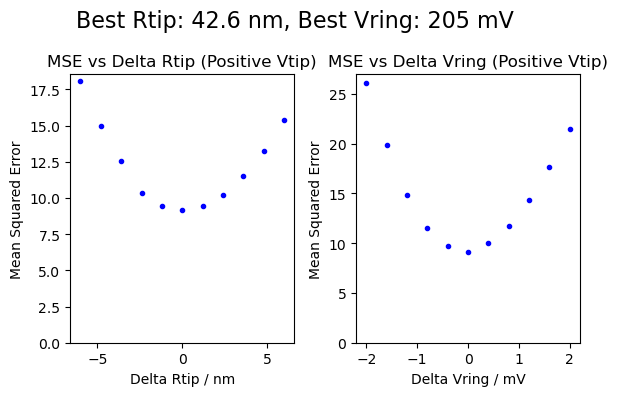

In [31]:
# CPD = -0.9 # V
CPD = 0 # V

# load experimental data
r_Htip_pos = np.loadtxt("data/exp_data_z_ringA_Vtip+.csv", delimiter=',')
r_Vtip_pos = np.loadtxt("data/exp_data_ringA_Vtip+.csv", delimiter=',')
mask = r_Vtip_pos[:, 0] <= 6.0-CPD
r_Vtip_pos = r_Vtip_pos[mask]
r_Htip_neg = np.loadtxt("data/exp_data_z.csv", delimiter=',', skiprows=1)
r_Vtip_neg = np.loadtxt("data/exp_data.csv", delimiter=',', skiprows=1)
r_Vtip_neg[:, 0] = -r_Vtip_neg[:, 0]  # Make voltages negative
mask = r_Vtip_neg[:, 0] >= -6.0-CPD
r_Vtip_neg = r_Vtip_neg[mask]

# load optimized parameters from fitting results
with open("fitting_results/fitting_metadata.json", "r") as f:
    fitting_metadata = json.load(f)
print('--- Fitting Results ---')
print(json.dumps(fitting_metadata, indent=4))

# positive Vtip
# 最適地前後のMSEの変化を調べる
Rtip_opt = fitting_metadata["positive_Vtip"]["Rtip_opt"]
Vring_opt = fitting_metadata["positive_Vtip"]["Vring_opt"]
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
MSE_Rtip = []
MSE_Vring = []
delta_Rtip_values = np.linspace(-6.0, 6.0, 11)  # nm
delta_Vring_values = np.linspace(-0.002, 0.002, 11)  # V
for delta_Rtip in delta_Rtip_values:
    Rtip_test = Rtip_opt + delta_Rtip
    ring_radii_Htip = [
        ring_radius_func(Rtip_test, Vring_opt, Vtip_fixed+CPD, Htip_val) for Htip_val in r_Htip_pos[:, 0]
    ]
    ring_radii_Vtip = [
        ring_radius_func(Rtip_test, Vring_opt, Vtip_val+CPD, Htip_fixed) for Vtip_val in r_Vtip_pos[:, 0]
    ]
    MSE = np.nanmean((r_Htip_pos[:, 1] - ring_radii_Htip) ** 2) + np.nanmean((r_Vtip_pos[:, 1] - ring_radii_Vtip) ** 2)
    MSE_Rtip.append(MSE)
MSE_Rtip = np.array(MSE_Rtip)
axes[0].plot(delta_Rtip_values, MSE_Rtip, 'b.')
axes[0].set_ylim(0, None)
axes[0].set_xlabel("Delta Rtip / nm")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("MSE vs Delta Rtip (Positive Vtip)")
for delta_Vring in delta_Vring_values:
    Vring_test = Vring_opt + delta_Vring
    ring_radii_Htip = [
        ring_radius_func(Rtip_opt, Vring_test, Vtip_fixed+CPD, Htip_val) for Htip_val in r_Htip_pos[:, 0]
    ]
    ring_radii_Vtip = [
        ring_radius_func(Rtip_opt, Vring_test, Vtip_val+CPD, Htip_fixed) for Vtip_val in r_Vtip_pos[:, 0]
    ]
    MSE = np.nanmean((r_Htip_pos[:, 1] - ring_radii_Htip) ** 2) + np.nanmean((r_Vtip_pos[:, 1] - ring_radii_Vtip) ** 2)
    MSE_Vring.append(MSE)
MSE_Vring = np.array(MSE_Vring)
axes[1].plot(delta_Vring_values*1e3, MSE_Vring, 'b.')
axes[1].set_ylim(0, None)
axes[1].set_xlabel("Delta Vring / mV")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_title("MSE vs Delta Vring (Positive Vtip)")
fig.suptitle(f"Best Rtip: {Rtip_opt:.1f} nm, Best Vring: {Vring_opt*1e3:.0f} mV", fontsize=16)
plt.tight_layout()
plt.show()


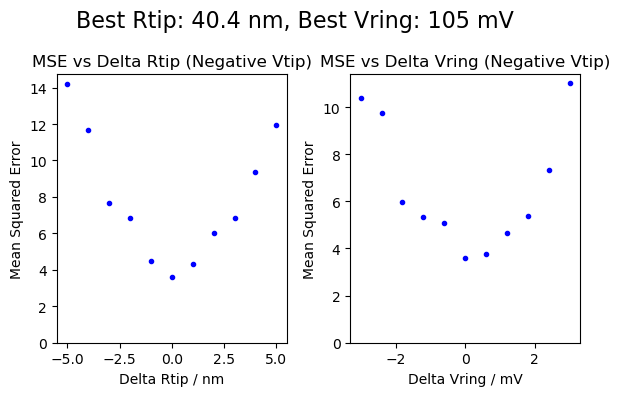

In [ ]:
# negative Vtip
# 最適地前後のMSEの変化を調べる
Rtip_opt_neg = fitting_metadata["negative_Vtip"]["Rtip_opt"]
Vring_opt_neg = fitting_metadata["negative_Vtip"]["Vring_opt"]
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
MSE_Rtip_neg = []
MSE_Vring_neg = []
delta_Rtip_values = np.linspace(-5.0, 5.0, 11)  # nm
delta_Vring_values = np.linspace(-0.003, 0.003, 11)  # V
for delta_Rtip in delta_Rtip_values:
    Rtip_test = Rtip_opt_neg + delta_Rtip
    ring_radii_Htip = [
        ring_radius_func(Rtip_test, Vring_opt_neg, Vtip_fixed_neg+CPD, Htip_val) for Htip_val in r_Htip_neg[:, 0]
    ]
    ring_radii_Vtip = [
        ring_radius_func(Rtip_test, Vring_opt_neg, Vtip_val+CPD, Htip_fixed) for Vtip_val in r_Vtip_neg[:, 0]
    ]
    MSE = np.nanmean((r_Htip_neg[:, 1] - ring_radii_Htip) ** 2 + np.nanmean((r_Vtip_neg[:, 1] - ring_radii_Vtip) ** 2)
    MSE_Rtip_neg.append(MSE))
MSE_Rtip_neg = np.array(MSE_Rtip_neg)
axes[0].plot(delta_Rtip_values, MSE_Rtip_neg, 'b.')
axes[0].set_ylim(0, None)
axes[0].set_xlabel("Delta Rtip / nm")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("MSE vs Delta Rtip (Negative Vtip)")
for delta_Vring in delta_Vring_values:
    Vring_test = Vring_opt_neg + delta_Vring
    ring_radii_Htip = [
        ring_radius_func(Rtip_opt_neg, Vring_test, Vtip_fixed_neg+CPD, Htip_val) for Htip_val in r_Htip_neg[:, 0]
    ]
    ring_radii_Vtip = [
        ring_radius_func(Rtip_opt_neg, Vring_test, Vtip_val+CPD, Htip_fixed) for Vtip_val in r_Vtip_neg[:, 0]
    ]
    MSE = np.nanmean((r_Htip_neg[:, 1] - ring_radii_Htip) ** 2) + np.nanmean((r_Vtip_neg[:, 1] - ring_radii_Vtip) ** 2)
    MSE_Vring_neg.append(MSE)
MSE_Vring_neg = np.array(MSE_Vring_neg)
axes[1].plot(delta_Vring_values*1e3, MSE_Vring_neg, 'b.')
axes[1].set_ylim(0, None)
axes[1].set_xlabel("Delta Vring / mV")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_title("MSE vs Delta Vring (Negative Vtip)")
fig.suptitle(f"Best Rtip: {Rtip_opt_neg:.1f} nm, Best Vring: {Vring_opt_neg*1e3:.0f} mV", fontsize=16)
plt.tight_layout()
plt.show()